# Sleep ECoG Processing 
##### my attempts to do this all in Python...

- Frequency band power analysis between sleep + wake data sets
- subject a0f66459, day 6

## Outline
- options
- load raw data
- separate out grid channels (1-64) and sleep vs. wake (1 hour each)
- visualize all 64 channels
- id channel 37 as bad - remove from set
- reshape into 20 trials 
- get power bands
- t-test, bar plot
- classify sleep vs. wake


In [91]:
# import things that might be useful to me
%matplotlib inline

# general use
import numpy as np
import pandas as pd 
import time
import h5py
import math
import scipy as sp
from scipy import signal
from scipy import stats
from sklearn import preprocessing

# plotting
import matplotlib.pyplot as plt
import altair as alt
import seaborn as sns

# custom functions here
import filtering_tools as filt

print('Pandas version:',pd.__version__)

Pandas version: 0.24.2


In [11]:
# options
plot_on = 1;
save_on = 0;

In [12]:
# load raw data

filename = r"C:\Users\sunh20\Documents\Projects\SleepClass_SS\ecog\processed_a0f66459_6.h5"
fin = h5py.File(filename, "r")
print(list(fin.keys()))
ecog_d = fin.get('dataset')
fs = int(fin.get('f_sample')[()])
chan_label = fin.get('chanLabels')


['Kurt_channels', 'SD_channels', 'allChanArtifactInds', 'chanLabels', 'dataset', 'f_sample', 'goodChanInds', 'standardizeDenoms', 'start_timestamp', 'start_timestamp_nw']


In [13]:
# data information
print('These are your variables:')
print('ecog_d:', ecog_d.shape, ecog_d.dtype)
print('fs:',fs)
print('chan_label:', chan_label.shape, chan_label.dtype)
print()
print(chan_label[()])

These are your variables:
ecog_d: (129, 42764078) float32
fs: 500
chan_label: () object

['Event', 'GRID1', 'GRID2', 'GRID3', 'GRID4', 'GRID5', 'GRID6', 'GRID7', 'GRID8', 'GRID9', 'GRID10', 'GRID11', 'GRID12', 'GRID13', 'GRID14', 'GRID15', 'GRID16', 'GRID17', 'GRID18', 'GRID19', 'GRID20', 'GRID21', 'GRID22', 'GRID23', 'GRID24', 'GRID25', 'GRID26', 'GRID27', 'GRID28', 'GRID29', 'GRID30', 'GRID31', 'GRID32', 'GRID33', 'GRID34', 'GRID35', 'GRID36', 'GRID37', 'GRID38', 'GRID39', 'GRID40', 'GRID41', 'GRID42', 'GRID43', 'GRID44', 'GRID45', 'GRID46', 'GRID47', 'GRID48', 'GRID49', 'GRID50', 'GRID51', 'GRID52', 'GRID53', 'GRID54', 'GRID55', 'GRID56', 'GRID57', 'GRID58', 'GRID59', 'GRID60', 'GRID61', 'GRID62', 'GRID63', 'GRID64', 'LID1', 'LID2', 'LID3', 'LID4', 'LID5', 'LID6', 'LID7', 'LID8', 'LAT1', 'LAT2', 'LAT3', 'LAT4', 'LAT5', 'LAT6', 'LMT1', 'LMT2', 'LMT3', 'LMT4', 'LPT1', 'LPT2', 'LPT3', 'LPT4', 'LPT5', 'LPT6', 'LTO1', 'LTO2', 'LTO3', 'LTO4', 'LTO5', 'LTO6', 'EOGL', 'EOGR', 'ECGL', 'ECGR'

In [14]:
# separate out grid data
# first index = event data (ignore)
ECOG_data = ecog_d[0:65,].transpose();
print('ECOG_data:',ECOG_data.shape)


ECOG_data: (42764078, 65)


In [15]:
# get sleep and wake times
t_start = 8*60*60 + 13*60 + 24 # seconds

# get sleep and wake times
t_wake = 8*60*60 + 59*60 + 36
t_sleep = 8*60*60 + 16*60*60 + 59*60 + 36

# adjust to get start indices for wake + sleep
t_wake = (int)((t_wake - t_start)*fs)
t_sleep = (int)((t_sleep - t_start)*fs)
t = np.arange(0,60*60,1/fs);

data_wake = ECOG_data[t_wake:t_wake+fs*math.ceil(t[-1]),]
data_sleep = ECOG_data[t_sleep:t_sleep+fs*math.ceil(t[-1]),]

print('t:',t.shape)
print('data_wake:', data_wake.shape)
print('data_sleep:', data_sleep.shape)

t: (1800000,)
data_wake: (1800000, 65)
data_sleep: (1800000, 65)


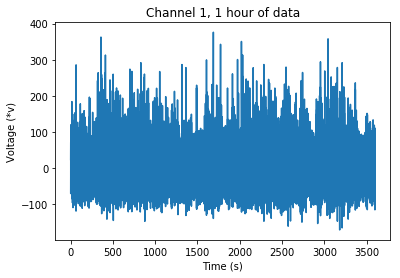

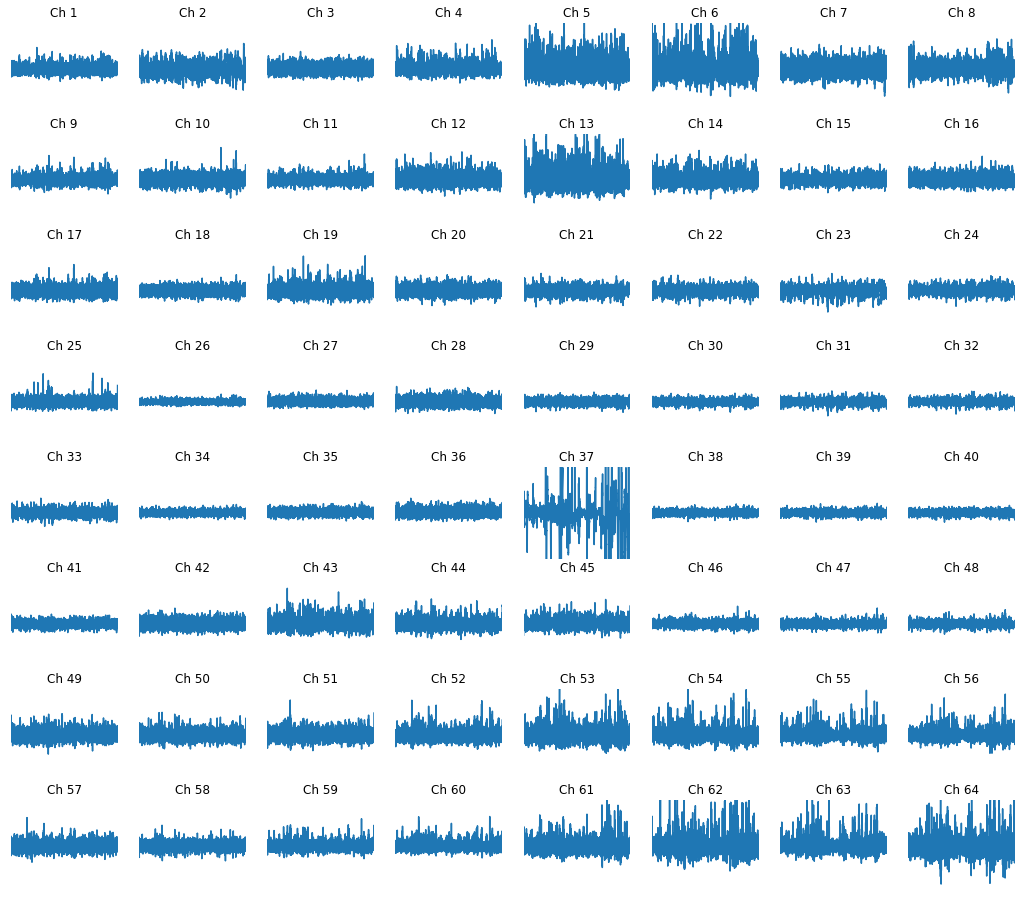

In [16]:
# visualize 64 channels
if plot_on:
    plt.figure
    plt.plot(t,data_wake[:,1])
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (*v)')
    plt.title('Channel 1, 1 hour of data')
    plt.figure(figsize=(18,16))
    
    for ch in range(0,64):
        plt.subplot(8,8,ch+1)
        plt.box(False)
        plt.plot(t[0:90000],data_wake[0:90000,ch+1])
        plt.axis([0, 60, -400, 400])
        plt.title('Ch ' + str(ch+1))
        plt.xticks(ticks=[], labels=[])
        plt.yticks(ticks=[], labels=[])
    

In [42]:
# remove ch 37 + make list of channels
chan = np.arange(0,65)
chan = np.delete(chan,37)

data_wake = np.delete(data_wake,37,1)
data_sleep = np.delete(data_sleep,37,1)

print('Removed channel 37')
print('data_wake:', data_wake.shape)
print('data_sleep:', data_sleep.shape)

Removed channel 37
data_wake: (1800000, 63)
data_sleep: (1800000, 63)


In [18]:
# reshape into 20 trials - 3 min long trials
num_trials = 20
trial_length = fs*60*3

data_wake_split = data_wake
data_wake_split = np.reshape(data_wake_split,[num_trials,trial_length,64])
print('data_wake_split:',data_wake_split.shape)

data_sleep_split = data_sleep
data_sleep_split = np.reshape(data_sleep_split,[num_trials,trial_length,64])
print('data_sleep_split:',data_sleep_split.shape)

# test that reshaping works as intended
# # first 10 items in ch 1
# print(data_sleep_split[0,0:10,1] == data_sleep[0:10,1])

# # item 90001 in ch 1
# print(data_sleep_split[1,1,1] == data_sleep[90001,1])

# # item 180001 in ch 3
# print(data_sleep_split[2,1,3] == data_sleep[180001,3])

data_wake_split: (20, 90000, 64)
data_sleep_split: (20, 90000, 64)


(90000, 64)


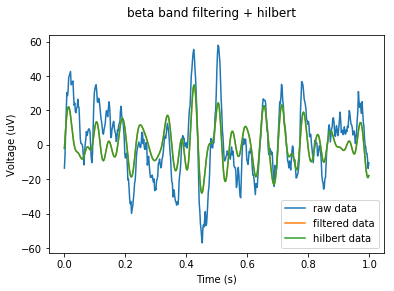

In [19]:
# test that the filters work
data = data_sleep_split[0,:,:]
print(data.shape)

data_filt = filt.flex_filter(data,fs,12,30,btype='bandpass')
data_hilb = sp.signal.hilbert(data_filt)

plt.figure
plt.plot(t[0:500],data[0:500,1],label='raw data')
plt.plot(t[0:500],data_filt[0:500,1],label='filtered data')
plt.plot(t[0:500],data_hilb[0:500,1].real,label='hilbert data')
plt.legend()
plt.suptitle('beta band filtering + hilbert')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.show()

In [20]:
# get power bands
pow_bands = [[1,4],[4,7],[8,13],[13,30],[30,70],[70,200]]
pow_bands_sleep = np.zeros((20,6,63))
pow_bands_wake = np.zeros((20,6,63))

# for each trial 1-20
start_time = time.time()

for tr in range(20):
    # get avg power for each frequency band
    for pwb in range(6):
        f_low = pow_bands[pwb][0]
        f_high = pow_bands[pwb][1]
        
        d_sl = data_sleep_split[tr,:,1:64]
             
        data_filt = filt.flex_filter(d_sl,fs,f_low,f_high,btype='bandpass')
        data_hilb = sp.signal.hilbert(data_filt)
        hilb_pow = np.abs(data_hilb)**2
        pow_bands_sleep[tr][pwb] = np.mean(hilb_pow, axis=0)
        
        d_w = data_wake_split[tr,:,1:64]

        data_filt = filt.flex_filter(d_w,fs,f_low,f_high,btype='bandpass')
        data_hilb = sp.signal.hilbert(data_filt)
        hilb_pow = np.abs(data_hilb)**2
        pow_bands_wake[tr][pwb] = np.mean(hilb_pow, axis=0)
        
    # print(np.mean(pow_bands_wake[tr][:][:],axis=-1))
    print('completed trial',tr,'of 20')
print("--- %s seconds elapsed ---" % (time.time() - start_time))


completed trial 0 of 20
completed trial 1 of 20
completed trial 2 of 20
completed trial 3 of 20
completed trial 4 of 20
completed trial 5 of 20
completed trial 6 of 20
completed trial 7 of 20
completed trial 8 of 20
completed trial 9 of 20
completed trial 10 of 20


KeyboardInterrupt: 

In [ ]:
# save pow band info 
# np.save('pow_bands.npy', [pow_bands_sleep, pow_bands_wake])

In [21]:
# load pow band info
pow_bands_sleep, pow_bands_wake = np.load('pow_bands.npy')

In [22]:
# t-test
p_sleep_mean = np.mean(np.mean(pow_bands_sleep,axis=-1),axis=0)
p_wake_mean = np.mean(np.mean(pow_bands_wake,axis=-1),axis=0)

p_sleep_ste = stats.sem(np.mean(pow_bands_sleep,axis=-1),axis=0)
p_wake_ste = stats.sem(np.mean(pow_bands_wake,axis=-1),axis=0)

t_stat, pval = stats.ttest_ind(np.mean(pow_bands_sleep,axis=-1),np.mean(pow_bands_wake,axis=-1))

P-values:
delta (1-4) 	2.8e-09	 ***
theta (4-7) 	0.22	 
alpha (8-13) 	0.0039	 **
beta (13-30) 	1.7e-08	 ***
gamma (30-70) 	1.3e-11	 ***
hgamma (70-200) 	1.9e-11	 ***


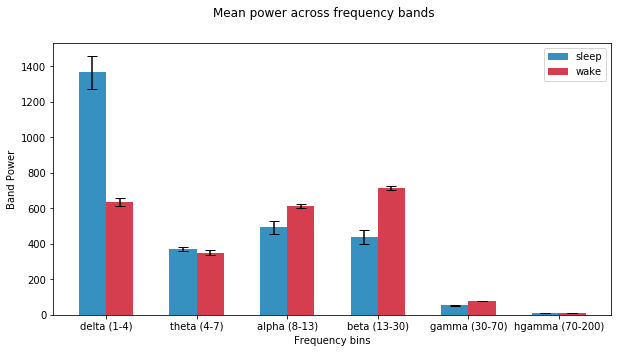

In [23]:
# bar plot mean pow bands

bar_labels = ("delta (1-4)","theta (4-7)","alpha (8-13)",
              "beta (13-30)","gamma (30-70)","hgamma (70-200)")
y_pos = np.arange(len(bar_labels))
bar_w = 0.3
 
plt.figure(figsize=(10,5))
plt.bar(y_pos,p_sleep_mean,bar_w,
        yerr=p_sleep_ste,
        capsize=5,
        label='sleep',
        color='#3690c0')
plt.bar(y_pos+bar_w,p_wake_mean,bar_w,
        yerr=p_wake_ste,
        capsize=5,
        label='wake',
        color='#d53e4f')
plt.grid(False)
plt.xticks(y_pos + bar_w/2, bar_labels)
plt.xlabel('Frequency bins')
plt.ylabel('Band Power')
plt.legend()
plt.suptitle('Mean power across frequency bands')

print('P-values:')

for i in np.arange(len(pval)):
    stars = '';
    p = pval[i]
    if p < 0.05:
        stars = stars + '*'
    if p < 0.01:
        stars = stars + '*'
    if p < 0.001:
        stars = stars + '*'
    print(bar_labels[i],'\t%.2g\t' % p,stars) 



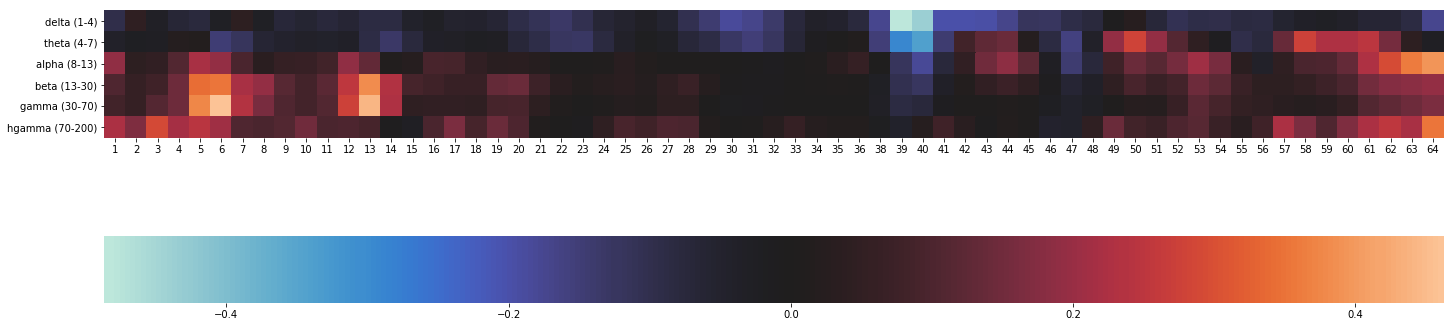

In [107]:
# do the same thing but now by electrode
chan = np.arange(0,65)
chan = np.delete(chan,37)
chan = np.delete(chan,0)

# make dataframes for sleep + wake electrodes
p_e_wake = pd.DataFrame(data=np.mean(pow_bands_wake,axis=0).transpose(),
                        columns=bar_labels,
                        index=chan)
p_e_wake.index.name = 'Electrode'
p_e_sleep = pd.DataFrame(data=np.mean(pow_bands_sleep,axis=0).transpose(),
                         columns=bar_labels,
                         index=chan)
p_e_sleep.index.name = 'Electrode'

# make difference dataframe - normalized
p_e_diff = p_e_wake - p_e_sleep
p_e_diff_norm = pd.DataFrame(data=preprocessing.normalize(np.array(p_e_diff),axis=0),
                             columns=bar_labels,
                             index=chan)
plt.figure(figsize=[24,12])
ax = sns.heatmap(p_e_diff_norm.transpose(),square=True,center=0,cbar_kws={"orientation": "horizontal"})


**Figure**: Heatmap showing the difference in frequency band power between wake vs. sleep (wake - sleep). Black indicates little difference, while blue indicates higher sleep band power and red indicates higher wake band power. We observe that there are electrode clusters that have preferentially increased band power in higher frequencies during wake (5-7, 12-14, 61-64). We also observe that electrodes 39-40 have preferentially increased band power in the lower frequencies during sleep.   
   
These observations suggest that these electrodes may be good candidates for predicting sleep vs. wake and may be located in brain regions that are functionally relevant or responsive to sleep/wake states.

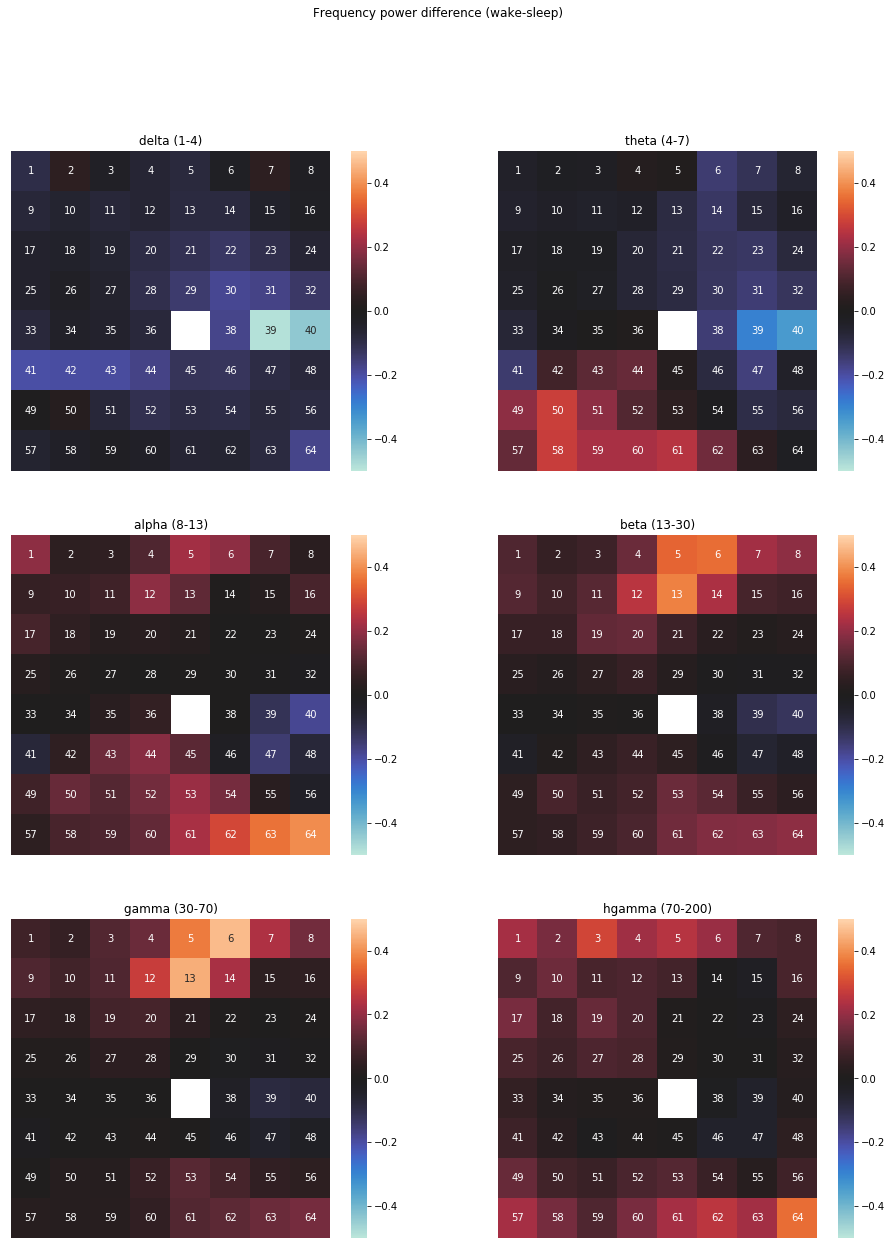

In [146]:
# 8x8 plots for each frequency band
chan = np.reshape(np.arange(1,65),[8,8])

fig = plt.figure(figsize=[16,20])
plt.suptitle('Frequency power difference (wake-sleep)')
for idx in np.arange(6):
    fband = bar_labels[idx]
    fdata = np.array(p_e_diff_norm[fband])
    fdata = np.reshape(np.insert(fdata,36,np.nan),[8,8])
    
    plt.subplot(3,2,idx+1)
    plt.title(fband)
    ax = sns.heatmap(fdata,square=True,
                     center=0,
                     annot=chan,
                     xticklabels=False,
                     yticklabels=False,
                     vmin=-0.5, vmax=0.5)


In [147]:
fig.savefig('fband_diff.png', dpi=300)

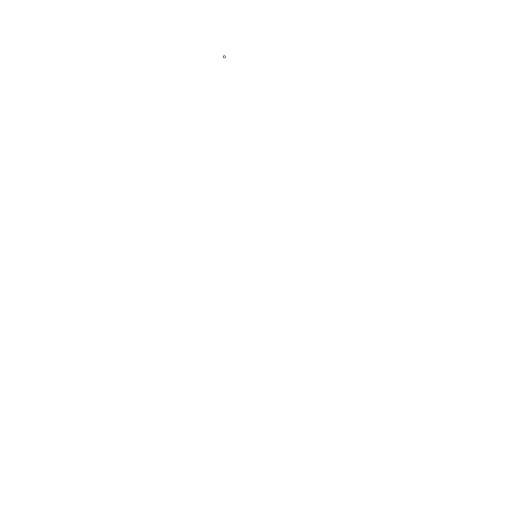

In [151]:
# video of delta power over time for the 64 electrodes

(6, 63)


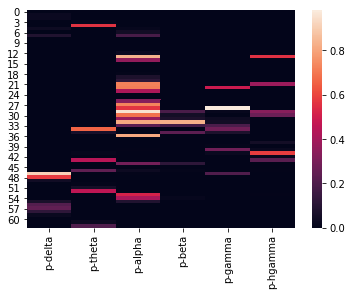

In [65]:
# t-test for each electrode + pow band
t_stat_e, pval_e = stats.ttest_ind(pow_bands_wake,pow_bands_sleep,axis=0)
print(pval_e.shape)

# add t-stat + pval to difference dataframe
col_names = ['p-delta','p-theta','p-alpha','p-beta','p-gamma','p-hgamma']
p_e_diff_pval = pd.DataFrame()
for idx in np.arange(6):
    p = pval_e[idx,]
    name = col_names[idx]
    p_e_diff_pval[name] = p
p_e_diff_pval

In [ ]:
# practice indexing lol
import numpy as np

a = np.array([[1, 2, 3, 0],[4, 5, 6, 0],[7, 8, 9, 0],[10, 11, 12, 0]])
print(a)

print(a[0,0])
print(a[2,2])

print(a[0:1,0])
print(a[0:2,0])

a = a.reshape([2, 2, 4])
print(a)
print(a[0,0,0])
print(a[0,0,1])
print(a**2)

In [ ]:
# some useful code i want to keep

# my tic toc
# start_time = time.time()
#print("--- %s seconds elapsed ---" % (time.time() - start_time))

# whos - will tell me all the variables in current workspace

# save to file
# np.save('test1.txt', a, fmt='%d')

In [ ]:
whos